In [1]:
%load_ext autoreload
%autoreload 2

In [103]:
import cirq

q = cirq.LineQubit.range(2)
c = cirq.Circuit(cirq.ZZ(*q))

In [104]:
noise = cirq.DepolarizingChannel(p=0.01)
# noise = cirq.BitFlipChannel(p=0.012)
sim = cirq.DensityMatrixSimulator(
    noise=noise,
)

In [105]:
import supermarq

experiment = supermarq.qcvv.CB(c, num_channels=5, dressed_measurement=False, pauli_channels=["II", "IX", "XI", "IZ", "XX", "YY"])
experiment.prepare_experiment(num_circuits=100, cycle_depths=[1, 2, 4, 6])
experiment.run_with_simulator(simulator=sim, repetitions=100)
experiment.collect_data()

Building circuits:   0%|          | 0/2400 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/4800 [00:00<?, ?it/s]

True

<Axes: xlabel='cycle_depth', ylabel='expectation'>

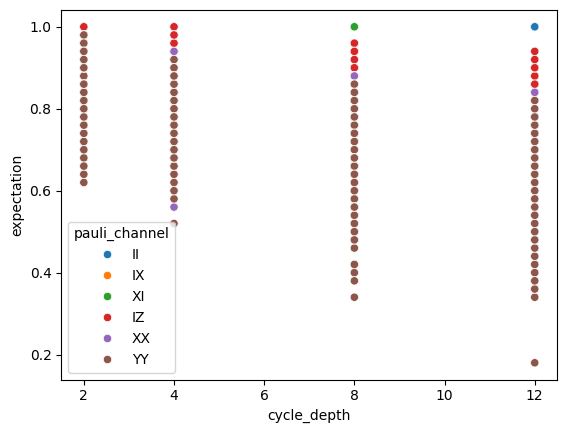

In [101]:
import seaborn as sns
sns.scatterplot(experiment.raw_data, x="cycle_depth", y="expectation", hue="pauli_channel", markers="circuit")

In [106]:
experiment.analyze_results()


,channel,p_error,p_error_std,p_spam,p_spam_std
0,II,0.000000,5.243313e-19,0.000000,2.799105e-18
1,IX,0.012291,1.217295e-03,0.049454,6.172443e-03
2,XI,0.013546,1.262990e-03,0.053769,6.409389e-03
3,IZ,0.012758,1.238524e-03,0.053567,6.235807e-03
4,XX,0.027924,2.121527e-03,0.101546,1.025928e-02
5,YY,0.027720,2.118392e-03,0.098038,1.029410e-02


In [111]:
1 - (1 - 4/3 * 0.01) ** 8

0.10181944072558036

In [94]:
experiment.analyze_results()

,channel,fidelity,fidelity_std,spam,spam_std
0,II,1.000000,3.073863e-18,1.000000,1.140844e-17
1,IX,0.998959,1.948658e-03,0.955093,6.970384e-03
2,XI,1.000353,2.216661e-03,0.955745,7.831385e-03
3,IZ,0.961195,6.299742e-03,0.887376,2.095810e-02
4,XX,1.001841,2.852754e-03,0.914647,9.744832e-03
5,YY,0.981287,8.499233e-03,0.798869,2.588591e-02


In [31]:
(0.941828/0.938564) ** -1

0.9965343990622492

In [78]:
experiment.samples[900].raw_circuit

0: ───I───Y───H[no_compile]───Z───H[no_compile]───Z───I───M───

In [9]:
experiment.raw_data[(experiment.raw_data.pauli_channel == "Z") & (experiment.raw_data.cycle_depth == 2)]["expectation"].mean()

0.9107199999999999

In [10]:
experiment.raw_data[(experiment.raw_data.pauli_channel == "Z")].groupby("cycle_depth").sum()

,pauli_channel,expectation
cycle_depth,,
2,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...,364.288
10,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...,293.246
20,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...,224.062


In [11]:
np.mean([(18.242/14.690) ** (1/(2-10)), (14.690/11.480) ** (1/(10-20)), (18.242/11.480) ** (1/(2-20))]), np.std([(18.242/14.690) ** (1/(2-10)), (14.690/11.480) ** (1/(10-20)), (18.242/11.480) ** (1/(2-20))])

NameError: name 'np' is not defined

In [ ]:
(1 - 0.01 * (4/3)) ** 2

0.9735111111111112